# 時間序列預測
- 以 LSTM 演算法預測航空公司的未來營收

## 載入相關套件

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

d:\Anaconda\envs\dp1bk\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 判斷 GPU 是否存在

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 載入資料
- 1949/1 ~ 1960/12

In [4]:
df = pd.read_csv("./nlp_data/airline-passengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


## 繪圖

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(-20.0, 0, '1959-05'),
  Text(0.0, 0, '1949-01'),
  Text(20.0, 0, '1950-09'),
  Text(40.0, 0, '1952-05'),
  Text(60.0, 0, '1954-01'),
  Text(80.0, 0, '1955-09'),
  Text(100.0, 0, '1957-05'),
  Text(120.0, 0, '1959-01'),
  Text(140.0, 0, '1960-09'),
  Text(160.0, 0, '')])

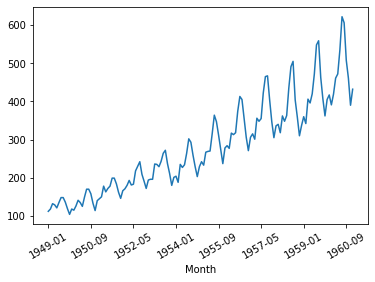

In [6]:
# 繪圖
df2 = df.set_index("Month")
df2.plot(legend = None)
plt.xticks(rotation = 30)

In [7]:
len(df2)

144

## 轉換資料
- 歸一化處理
- 資料分割

In [8]:
from sklearn.preprocessing import MinMaxScaler

look_back = 1

# 函數 : 以前 N 期資料為 X, 當前資料為 Y
def create_dataset(data1, look_back):
    x, y = [], []
    for i in range(len(data1)-look_back-1):
        _x = data1[i:(i+look_back)]
        _y = data1[i+look_back]
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

dataset = df2[["Passengers"]].values.astype("float32")

# X 常態化
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# 資料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
dataset.shape, trainY.shape

((144, 1), torch.Size([94, 1]))

In [9]:
dataset[-1]

array([0.6332046], dtype=float32)

In [10]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([94, 1, 1]),
 torch.Size([94, 1]),
 torch.Size([46, 1, 1]),
 torch.Size([46, 1]))

In [11]:
torch.cat((trainX.reshape(trainX.shape[0], trainX.shape[1]), trainY), axis = 1)

tensor([[0.0154, 0.0270],
        [0.0270, 0.0541],
        [0.0541, 0.0483],
        [0.0483, 0.0328],
        [0.0328, 0.0598],
        [0.0598, 0.0849],
        [0.0849, 0.0849],
        [0.0849, 0.0618],
        [0.0618, 0.0290],
        [0.0290, 0.0000],
        [0.0000, 0.0270],
        [0.0270, 0.0212],
        [0.0212, 0.0425],
        [0.0425, 0.0714],
        [0.0714, 0.0598],
        [0.0598, 0.0405],
        [0.0405, 0.0869],
        [0.0869, 0.1274],
        [0.1274, 0.1274],
        [0.1274, 0.1042],
        [0.1042, 0.0560],
        [0.0560, 0.0193],
        [0.0193, 0.0695],
        [0.0695, 0.0792],
        [0.0792, 0.0888],
        [0.0888, 0.1429],
        [0.1429, 0.1139],
        [0.1139, 0.1313],
        [0.1313, 0.1429],
        [0.1429, 0.1834],
        [0.1834, 0.1834],
        [0.1834, 0.1544],
        [0.1544, 0.1120],
        [0.1120, 0.0811],
        [0.0811, 0.1197],
        [0.1197, 0.1293],
        [0.1293, 0.1467],
        [0.1467, 0.1718],
        [0.1

##  建立模型

### 参数列表
- input_size：x的特征维度
- hidden_size：隐藏层的特征维度
- num_layers：lstm隐层的层数，默认为1
- bias：False则bih=0和bhh=0. 默认为True
- batch_first：True则输入输出的数据格式为 (batch, seq, feature)
- dropout：除最后一层，每一层的输出都进行dropout，默认为: 0
- bidirectional：True则为双向lstm默认为False
- 输入：input, (h0, c0)
- 输出：output, (hn,cn)

### 输入数据格式
- input(seq_len, batch, input_size)
- h0(num_layers * num_directions, batch, hidden_size)
- c0(num_layers * num_directions, batch, hidden_size)

### 输出数据格式：
- output(seq_len, batch, hidden_size * num_directions)
- hn(num_layers * num_directions, batch, hidden_size)
- cn(num_layers * num_directions, batch, hidden_size)

In [14]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size = 4, num_layers = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(1, self.hidden_size, num_layers = self.num_layers, batch_first = True)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        # print(x.shape)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        # print(h_0.shape)
        # print(c_0.shape)
        # print(h_out.shape)

        # 取最後一層的 h, 並轉成二維
        h_out = h_out[-1].view(-1, self.hidden_size)
        return self.fc(h_out)

# 訓練資料較少, 所以只需在 cpu 上執行即可
model = TimeSeriesModel(look_back, hidden_size = 4, num_layers = 1)

## 模型訓練

In [15]:
num_epochs = 2000
learning_rate = 0.01

def train(trainX, trainY):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX)
        if epoch <= 0: print(outputs.shape)
        loss = criterion(outputs, trainY)    
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

train(trainX, trainY)

torch.Size([94, 1])
Epoch: 0, loss: 0.06415
Epoch: 100, loss: 0.00257
Epoch: 200, loss: 0.00193
Epoch: 300, loss: 0.00191
Epoch: 400, loss: 0.00190
Epoch: 500, loss: 0.00190
Epoch: 600, loss: 0.00190
Epoch: 700, loss: 0.00190
Epoch: 800, loss: 0.00190
Epoch: 900, loss: 0.00190
Epoch: 1000, loss: 0.00190
Epoch: 1100, loss: 0.00190
Epoch: 1200, loss: 0.00190
Epoch: 1300, loss: 0.00190
Epoch: 1400, loss: 0.00190
Epoch: 1500, loss: 0.00190
Epoch: 1600, loss: 0.00190
Epoch: 1700, loss: 0.00190
Epoch: 1800, loss: 0.00190
Epoch: 1900, loss: 0.00190


## 模型評估

In [16]:
model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()
trainPredict.shape

(94, 1)

In [17]:
trainY.shape, trainPredict.shape

(torch.Size([94, 1]), (94, 1))

## 預測後, 還原常態化

In [18]:
from sklearn.metrics import mean_squared_error
import math

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f"train RMSE: {trainScore: .2f} ")
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f"Test RMSE: {testScore:.2f}")

(94, 1) (94, 1)
train RMSE:  22.56 
Test RMSE: 56.87


## 繪製實際資料和預測資料的圖表

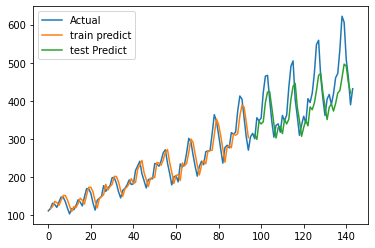

In [19]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+look_back, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset), label = "Actual")
plt.plot(trainPredictPlot, label = "train predict")
plt.plot(testPredictPlot, label = "test Predict")
plt.legend()
plt.show()

## 改變 Loopback = 3:

In [20]:
# 以前期資料 為 X, 當前期資料為Y
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size = 4, num_layers = 1)
train(trainX, trainY)

torch.Size([92, 1])
Epoch: 0, loss: 0.11633
Epoch: 100, loss: 0.00339
Epoch: 200, loss: 0.00297
Epoch: 300, loss: 0.00227
Epoch: 400, loss: 0.00185
Epoch: 500, loss: 0.00166
Epoch: 600, loss: 0.00157
Epoch: 700, loss: 0.00154
Epoch: 800, loss: 0.00152
Epoch: 900, loss: 0.00150
Epoch: 1000, loss: 0.00148
Epoch: 1100, loss: 0.00146
Epoch: 1200, loss: 0.00144
Epoch: 1300, loss: 0.00142
Epoch: 1400, loss: 0.00141
Epoch: 1500, loss: 0.00140
Epoch: 1600, loss: 0.00139
Epoch: 1700, loss: 0.00139
Epoch: 1800, loss: 0.00139
Epoch: 1900, loss: 0.00138


## 模型訓練, 評估與繪製圖表

In [23]:
from sklearn.metrics import mean_squared_error
import math

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f"train RMSE: {trainScore: .2f} ")
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f"Test RMSE: {testScore:.2f}")

(92, 1) (92, 1)
train RMSE:  19.24 
Test RMSE: 71.05


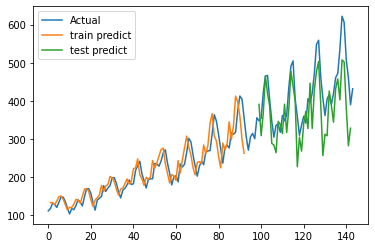

In [24]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

## Stacked LSTM

In [25]:
# 以前期資料為 X, 當期資料為 Y, 將LSTM層數設為 3
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size = 4, num_layers = 3)
train(trainX, trainY)

torch.Size([92, 1])
Epoch: 0, loss: 0.04822
Epoch: 100, loss: 0.00455
Epoch: 200, loss: 0.00159
Epoch: 300, loss: 0.00150
Epoch: 400, loss: 0.00147
Epoch: 500, loss: 0.00143
Epoch: 600, loss: 0.00137
Epoch: 700, loss: 0.00132
Epoch: 800, loss: 0.00124
Epoch: 900, loss: 0.00117
Epoch: 1000, loss: 0.00113
Epoch: 1100, loss: 0.00110
Epoch: 1200, loss: 0.00107
Epoch: 1300, loss: 0.00111
Epoch: 1400, loss: 0.00103
Epoch: 1500, loss: 0.00101
Epoch: 1600, loss: 0.00099
Epoch: 1700, loss: 0.00098
Epoch: 1800, loss: 0.00095
Epoch: 1900, loss: 0.00093


In [26]:
from sklearn.metrics import mean_squared_error
import math

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 還原常態化的訓練及測試資料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f"train RMSE: {trainScore: .2f} ")
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f"Test RMSE: {testScore:.2f}")

(92, 1) (92, 1)
train RMSE:  15.67 
Test RMSE: 75.49


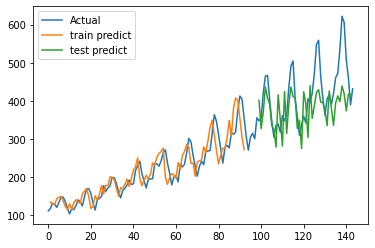

In [27]:
# 訓練資料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 測試資料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()